# Feature Ingeneering I

## Pakete laden

In [1]:
# Datentypen
import pandas as pd
import numpy as np
pd.set_option('display.precision',2)
np.set_printoptions(precision=3)
import datetime as dt

# Abbildungen
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['axes.xmargin'] = 0
plt.rcParams["figure.figsize"] = (8, 6)
%matplotlib widget
import seaborn as sns

# sklearn für preprocessing und PCA
from sklearn import preprocessing
from sklearn.decomposition import PCA

# statsmodels für Regression
from statsmodels import api as sm
import statsmodels.formula.api as smf

# widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

## Import der Daten (Strom und Commodities)

In [2]:
# Datum wird als Index gesetzt 
price = pd.read_excel('Terminpreise.xlsx',sheet_name='Import',names=['Datum','Peak','Base','Gas','CO2','Kohle'],index_col=0,\
                     parse_dates=[0], dtype={'Last':np.float64,'Preis':np.float64})
price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 677 entries, 2016-01-04 to 2018-08-08
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Peak    677 non-null    float64
 1   Base    677 non-null    float64
 2   Gas     677 non-null    float64
 3   CO2     677 non-null    float64
 4   Kohle   677 non-null    float64
dtypes: float64(5)
memory usage: 31.7 KB


In [3]:
price

,Peak,Base,Gas,CO2,Kohle
Datum,,,,,
2016-01-04,33.33,26.32,15.77,8.20,5.44
2016-01-05,32.96,25.80,15.86,8.16,5.44
2016-01-06,32.78,25.80,15.83,7.93,5.42
2016-01-07,32.35,25.54,15.95,7.70,5.38
2016-01-08,32.17,25.29,15.45,7.58,5.35
...,...,...,...,...,...
2018-08-02,54.18,44.10,20.91,17.37,10.33
2018-08-03,54.58,44.60,21.21,17.37,10.33
2018-08-06,55.25,45.11,21.44,17.37,10.50


In [4]:
# Anzahl der Datenpunkte
T = np.int64(len(price))

## Datenvisualisierung

### Darstellung im Zeitablauf 

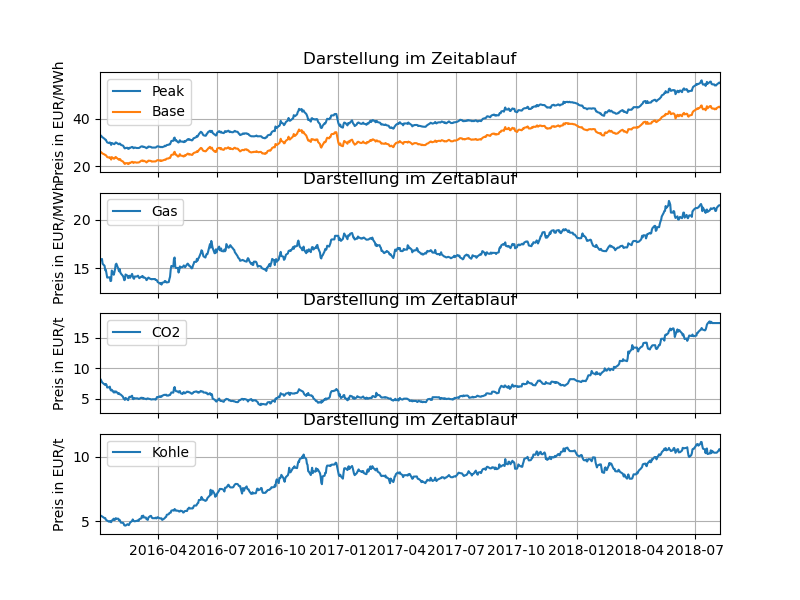

In [5]:
ind = ["EUR/MWh","EUR/MWh","EUR/t","EUR/t"]
zeig = [[0,1],2,3,4]
fig, ax =plt.subplots(nrows=4,ncols=1,**{'figsize': (8, 6)},sharex ='all')
for i in range(0,4):
    lin=ax[i].plot(price.index,price.iloc[:,zeig[i]],label=price.columns[zeig[i]])
    ax[i].set(ylabel='Preis in '+ind[i],title='Darstellung im Zeitablauf')
    ax[i].grid()
    ax[i].margins(0,.1);
    ax[i].legend()

### Darstellung Relation mit Scatterplot

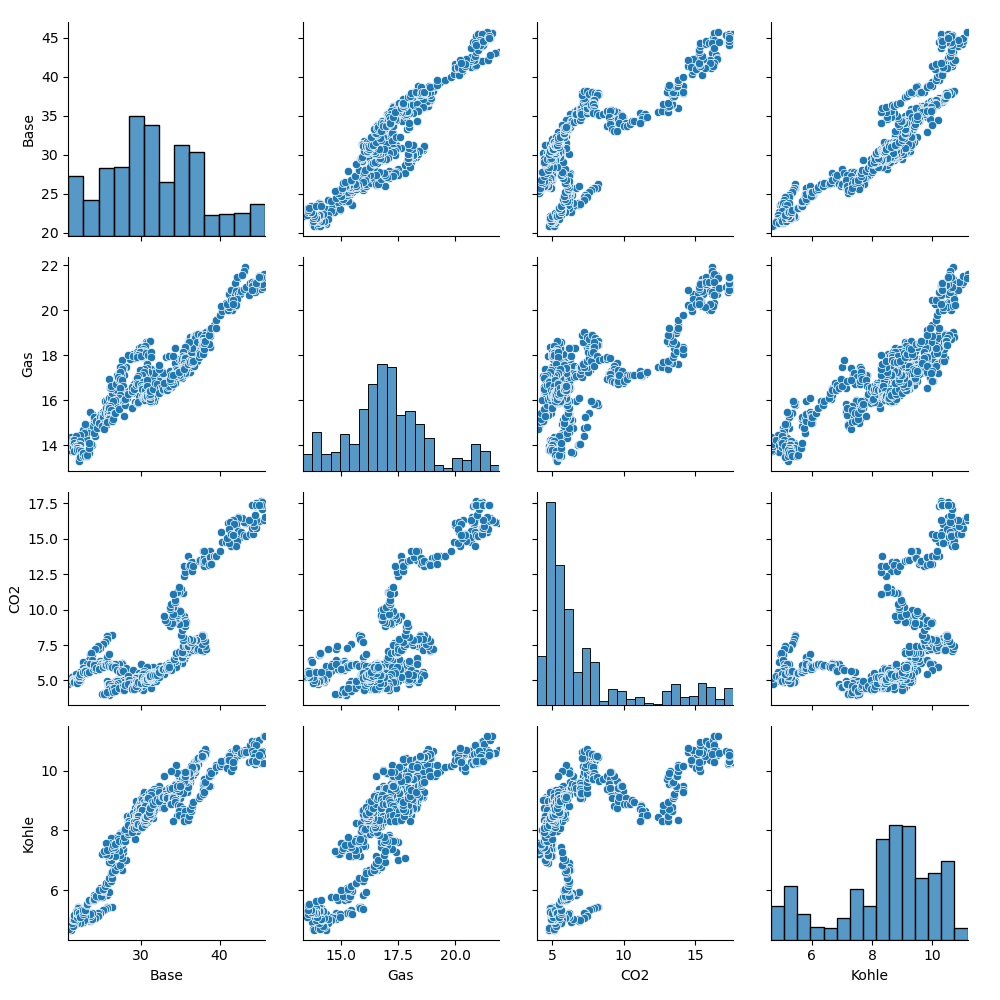

In [6]:
# Strom Base, Gas, CO2, Kohle
g = sns.PairGrid(price.iloc[:,1:])
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot);

### Korrelation

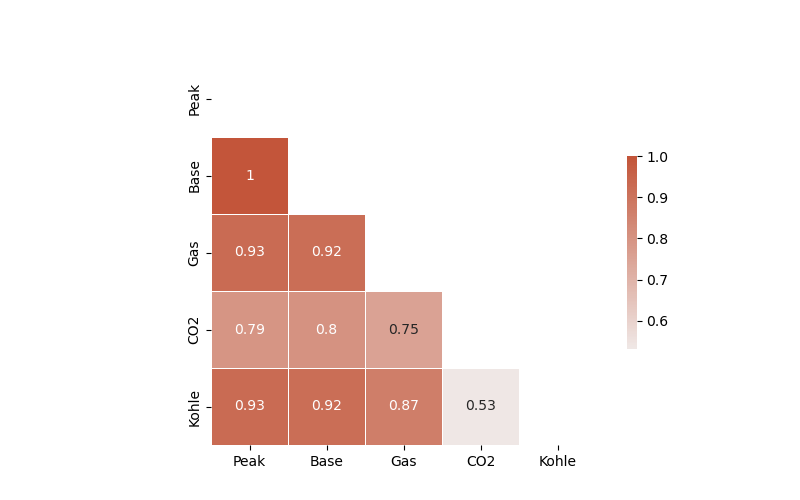

In [7]:
# Compute the correlation matrix
corr = price.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(8, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0.5,annot =True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

Berechnung Variance Inflation Factor

In [8]:
R0 = pd.DataFrame(price.iloc[:,1:].corr().values)
R0

,0,1,2,3
0,1.00,0.92,0.80,0.92
1,0.92,1.00,0.75,0.87
2,0.80,0.75,1.00,0.53
3,0.92,0.87,0.53,1.00


## Rekonstruktion VIF anhand der Regression

<img src="images/VIF.png" alt="VIF" width="800" >

Modell zur Erklärung der Gaspreise durch die CO2-Preise [Peak~Gas,CO2,Kohle]

In [9]:
mdl=smf.ols('Gas ~ CO2 + Kohle',data=price).fit()
print("R^2="+'%0.2f'%mdl.rsquared)

R^2=0.87


Modell mit weiteren Rohwaren zur Analyse der Verschlechterung der Parameterschätzung

In [10]:
VIF_gas = 1/(1-mdl.rsquared)
print("VIF(Gas)="+'%0.2f'%VIF_gas)

VIF(Gas)=7.70


Variance Inflation Factor der Brennstoffpreise untereinander 

In [11]:
VIF = np.diag(np.linalg.inv(R0.to_numpy()[1:,1:]))
VIF

array([7.704, 2.646, 4.687])

# PCA-Analyse

## Standardisierung

Standardisierung ist insb. bei Daten mit unterschiedlichen Einheiten bzw. unterschiedlichen Daten-Spannweiten notwendig. <br>
In vorliegenden Fall werden alle Merkmale wie folgt standarisiert:
    $ z = \frac{x -\mu}{\sigma}$

The sklearn.preprocessing module includes scaling, centering, normalization, binarization methods.
Die Klasse StandardScaler besitzt sowohl Attribute als auch Methoden, um eine standardisierung der Daten durchzuführen.<br>

<img src="images/standardscaler.png" alt="VIF" width="600" >

In [12]:
# Scalerinstanz 
scaler = preprocessing.StandardScaler().fit(price.iloc[:,1:])
# normierte Preise
price_norm = scaler.transform(price.iloc[:,1:]) 

In [13]:
print(price_norm.shape)
price_norm

(677, 4)


array([[-0.92 , -0.726,  0.231, -1.831],
       [-1.009, -0.676,  0.22 , -1.831],
       [-1.009, -0.693,  0.156, -1.846],
       ...,
       [ 2.29 ,  2.444,  2.796,  1.268],
       [ 2.301,  2.463,  2.796,  1.332],
       [ 2.262,  2.457,  2.796,  1.274]])

In [14]:
# Mittelwert
scaler.mean_

array([31.707, 17.069,  7.374,  8.432])

## Datenreduktion mit der PCA

https://scikit-learn.org/stable/modules/decomposition.html

#class sklearn.decomposition.PCA(n_components=None, *, copy=True, whiten=False, svd_solver='auto', 
#tol=0.0, iterated_power='auto', n_oversamples=10, power_iteration_normalizer='auto', random_state=None)

Die Klasse PCA besitzt sowohl Attribute als auch Methoden, um Ergebnisse der PCA darzustellen.<br>
Die wichtigsten sind in folgender Tabelle zusammengefasst:

<img src="images/classpca.png" alt="VIF" width="600" >

In [15]:
# Anzahl der zu betrachtenden Komponenten
anz_components = 4
# Instanziierung des Objektes
pcaobj = PCA(n_components=anz_components)
# Aufruf der PCA-Methode
pcaobj.fit(price_norm)
# Rückgabe der Faktorladungen
pca_latents = pcaobj.transform(price_norm)

**Darstellung Erklärungsgehalt der Faktorladungen**<br>

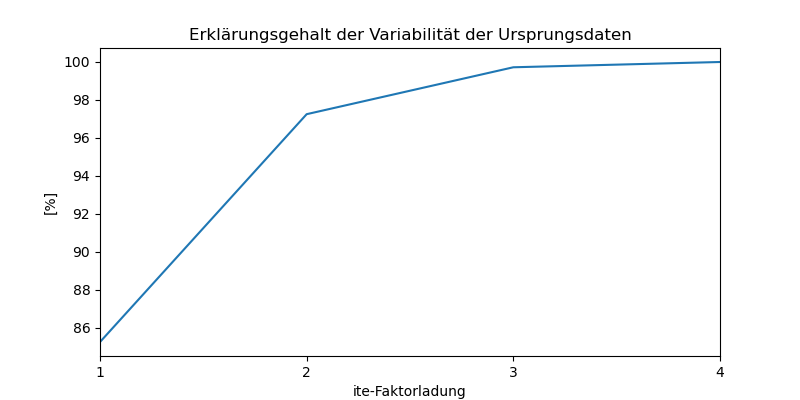

In [16]:
pcaobj.explained_variance_ratio_=pcaobj.explained_variance_ratio_*100
pcaobj.explained_variance_ratio_
fig, ax =plt.subplots(nrows=1,ncols=1,**{'figsize': (8, 4)});
plt.plot(pcaobj.explained_variance_ratio_.cumsum())
ax.set(ylabel='[%]',xlabel='ite-Faktorladung',title = "Erklärungsgehalt der Variabilität der Ursprungsdaten",xticks =range(0,4),xticklabels=range(1,5));

**Darstellung der latenten Faktoren**<br>

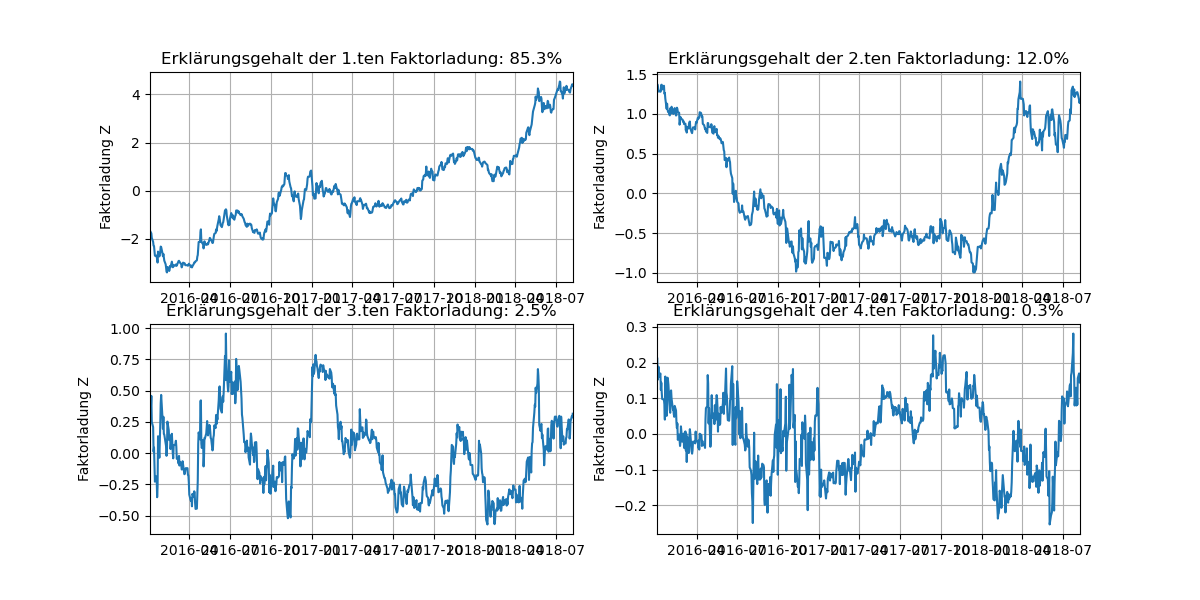

In [17]:
fig=plt.figure(figsize=(12,6))
for i,j in enumerate(range(1,anz_components+1)):
    ax=fig.add_subplot(2, 2, j)
    ax.plot(price.index,pca_latents[:,i])
    ax.set(ylabel='Faktorladung Z',title = "Erklärungsgehalt der "+'%0.0f' %j +".ten Faktorladung: "  +'%0.1f' % pcaobj.explained_variance_ratio_[i]+'%')
    ax.grid()

**Darstellung der Hauptkomponenten**<br>
(n_components, n_features)

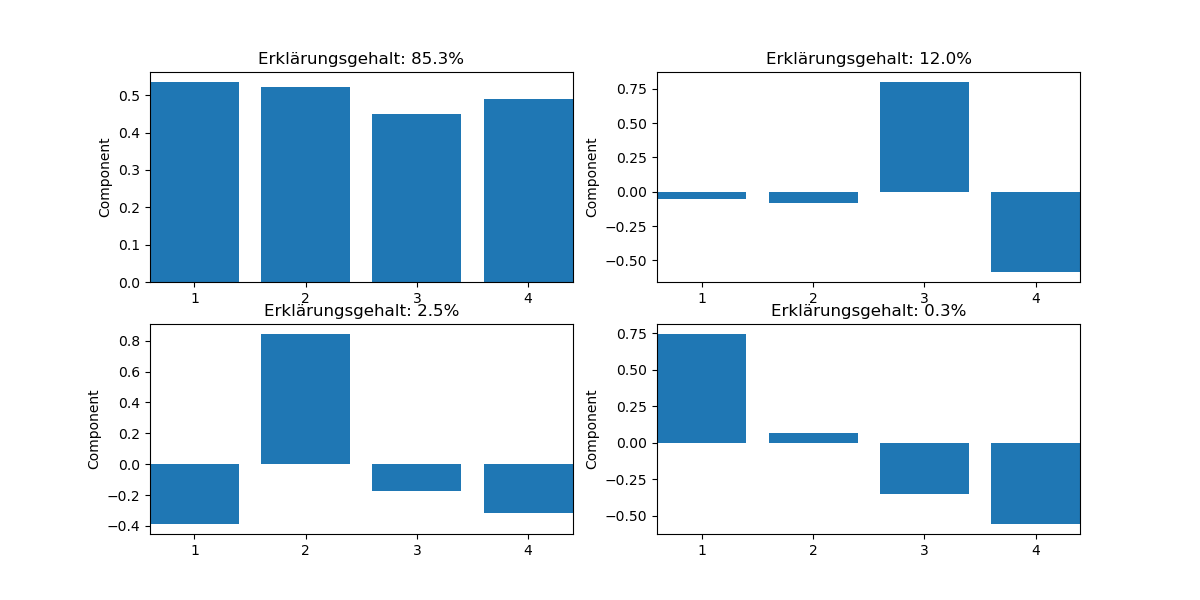

In [18]:
fig=plt.figure(figsize=(12,6))
for i,j in enumerate(range(1,anz_components+1)):
    ax=fig.add_subplot(2, 2, j)
    ax.bar(range(0,4),pcaobj.components_[i,:])
    ax.set(ylabel='Component',title = "Erklärungsgehalt: "+'%0.1f' % pcaobj.explained_variance_ratio_[i]+'%',xticks =range(0,4),xticklabels=range(1,5))

## Rekonstruktion der Daten

Im folgenden werden die ersten x Faktorladungen verwendet 
Aufgabe:
Betrachten Sie durch Variation von fakt_anz figure 7 und identifizieren welche Bewegungsmuster gut und weniger genau reproduziert werden können.

In [19]:
#Erstellung eines sliders
components_choose = widgets.IntSlider(
    value=2,
    min=1,
    max=4,
    step=1,
    description='components_choose:',
)
components_choose

IntSlider(value=2, description='components_choose:', max=4, min=1)

In [20]:
pcaobj.components_

array([[ 0.535,  0.521,  0.449,  0.491],
       [-0.055, -0.082,  0.803, -0.587],
       [-0.391,  0.847, -0.171, -0.316],
       [ 0.747,  0.064, -0.353, -0.56 ]])

**normierte rekonstruierte Daten**

In [21]:
# wichtig: Dimensionen der Objekte beachten pcaobj.components_(n_components, n_features)
pcaobj.reconstr_norm=[]
pcaobj.reconstr_norm =pca_latents[:,:components_choose.value]@pcaobj.components_[:components_choose.value,:]

**rekonstruierte Daten**

In [22]:
pcaobj.reconstr=[]
pcaobj.reconstr=scaler.inverse_transform(pcaobj.reconstr_norm)
# Kurzform von: pcaobj.reconstr=pcaobj.reconstr_norm*np.sqrt(scaler.var_)+scaler.mean_

**Abbildung von Orginal und rekonstruierte Zeitreihe**

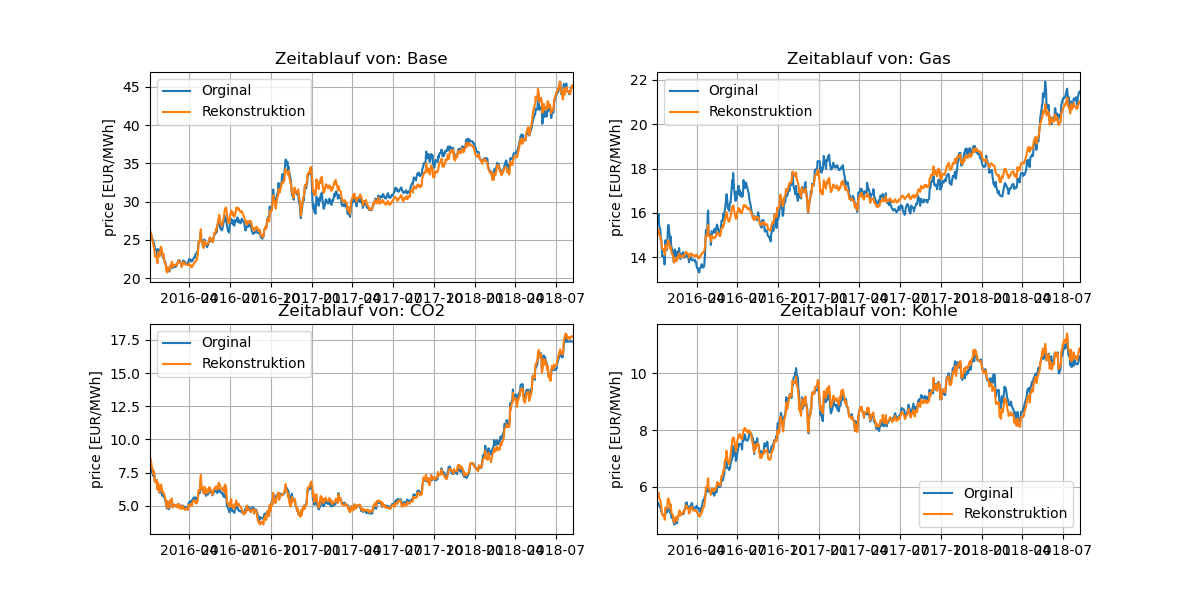

In [23]:
fig=plt.figure(figsize=(12,6))
for i,j in enumerate(range(1,anz_components+1)):
    ax=fig.add_subplot(2, 2, j)
    lin1,=ax.plot(price.index,price.iloc[:,j],label='Orginal')
    lin2,=ax.plot(price.index,pcaobj.reconstr[:,i],label='Rekonstruktion')
    ax.set(ylabel='price [EUR/MWh]',title='Zeitablauf von: ' + price.columns[j],)
    ax.legend(handles = [lin1,lin2])
    ax.grid()

## Regressionsmodellauf auf Basis PCA

**Datenauswahl und Vorbereitung**

In [24]:
# Ausfahl der latenten Faktorladungen als Regressoren 
x = pca_latents[:,:components_choose.value]
# es soll der Spread modelliert werden
y = price["Peak"]-price["Base"];
scaler = preprocessing.StandardScaler().fit(y.values.reshape(-1, 1))
y_norm = scaler.transform(y.values.reshape(-1, 1)) 

**Durchführung der Regression**

In [25]:
#Regressionsmodell
mdl1=sm.OLS(y_norm,x).fit()

**Statistische Auswertung**

In [26]:
mdl1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.923
Model:                            OLS   Adj. R-squared (uncentered):              0.922
Method:                 Least Squares   F-statistic:                              4021.
Date:                Tue, 18 Apr 2023   Prob (F-statistic):                        0.00
Time:                        09:27:13   Log-Likelihood:                         -94.618
No. Observations:                 677   AIC:                                      193.2
Df Residuals:                     675   BIC:                                      202.3
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5154      0.006     88.869      0.000       0.504       0.527
x2            -0.1859      0.015    -12.023      0.000      -0.216      -0.156
==============================================================================
Omnibus:                       18.531   Durbin-Watson:                   0.222
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.162
Skew:                           0.359   Prob(JB):                     4.19e-05
Kurtosis:                       3.448   Cond. No.                         2.67
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Darstellung des Verlaufs**

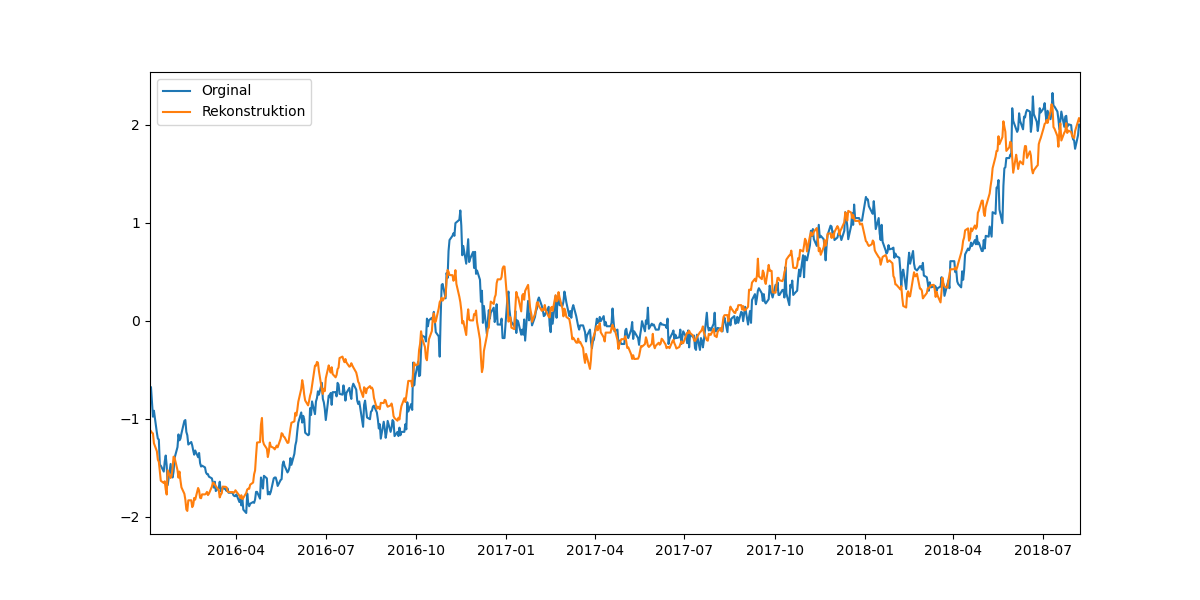

In [29]:
fig,ax=plt.subplots(figsize=(12,6))
lin1,=ax.plot(price.index,y_norm,label='Orginal')
lin2,=ax.plot(price.index,mdl1.predict(x),label='Rekonstruktion')
ax.legend();